# Required packages

```bash
$ pip install pydantic langchain langchain-community langchain-core langchain-openai
```

In [1]:
%pip install pydantic langchain langchain-community langchain-core langchain-openai

DEPRECATION: Loading egg at /home/neddy/wilma-venv/lib/python3.12/site-packages/gptcache-0.1.44-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import base64
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
# stuff only required for jupyter display
from IPython.core.display import Image as DisplayImage
from IPython.display import display
from IPython.core.display import HTML

# Environment Variables

In [7]:
# Setup required parameters to use AI-verde's OpenAI-compatible API
model_name = "Llama-3.2-11B-Vision-Instruct"
llm_host = os.environ.get('OPENAI_API_BASE', 'https://llm-api.cyverse.org/v1')
api_key = os.environ.get('OPENAI_API_KEY', '')

In [8]:
# directly using langchain ChatOpenAI
llm = ChatOpenAI(
    model=model_name,
    temperature=0,
    api_key=api_key,
    base_url=llm_host,
)

In [9]:
llm.invoke("Hello, how are you?") # validate we can talk with the LLM

AIMessage(content="I'm just a language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 41, 'total_tokens': 86, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.2-11B-Vision-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3505ef61-367e-4da3-8edc-8985f38494fa-0', usage_metadata={'input_tokens': 41, 'output_tokens': 45, 'total_tokens': 86, 'input_token_details': {}, 'output_token_details': {}})

# Visual Question/Answering

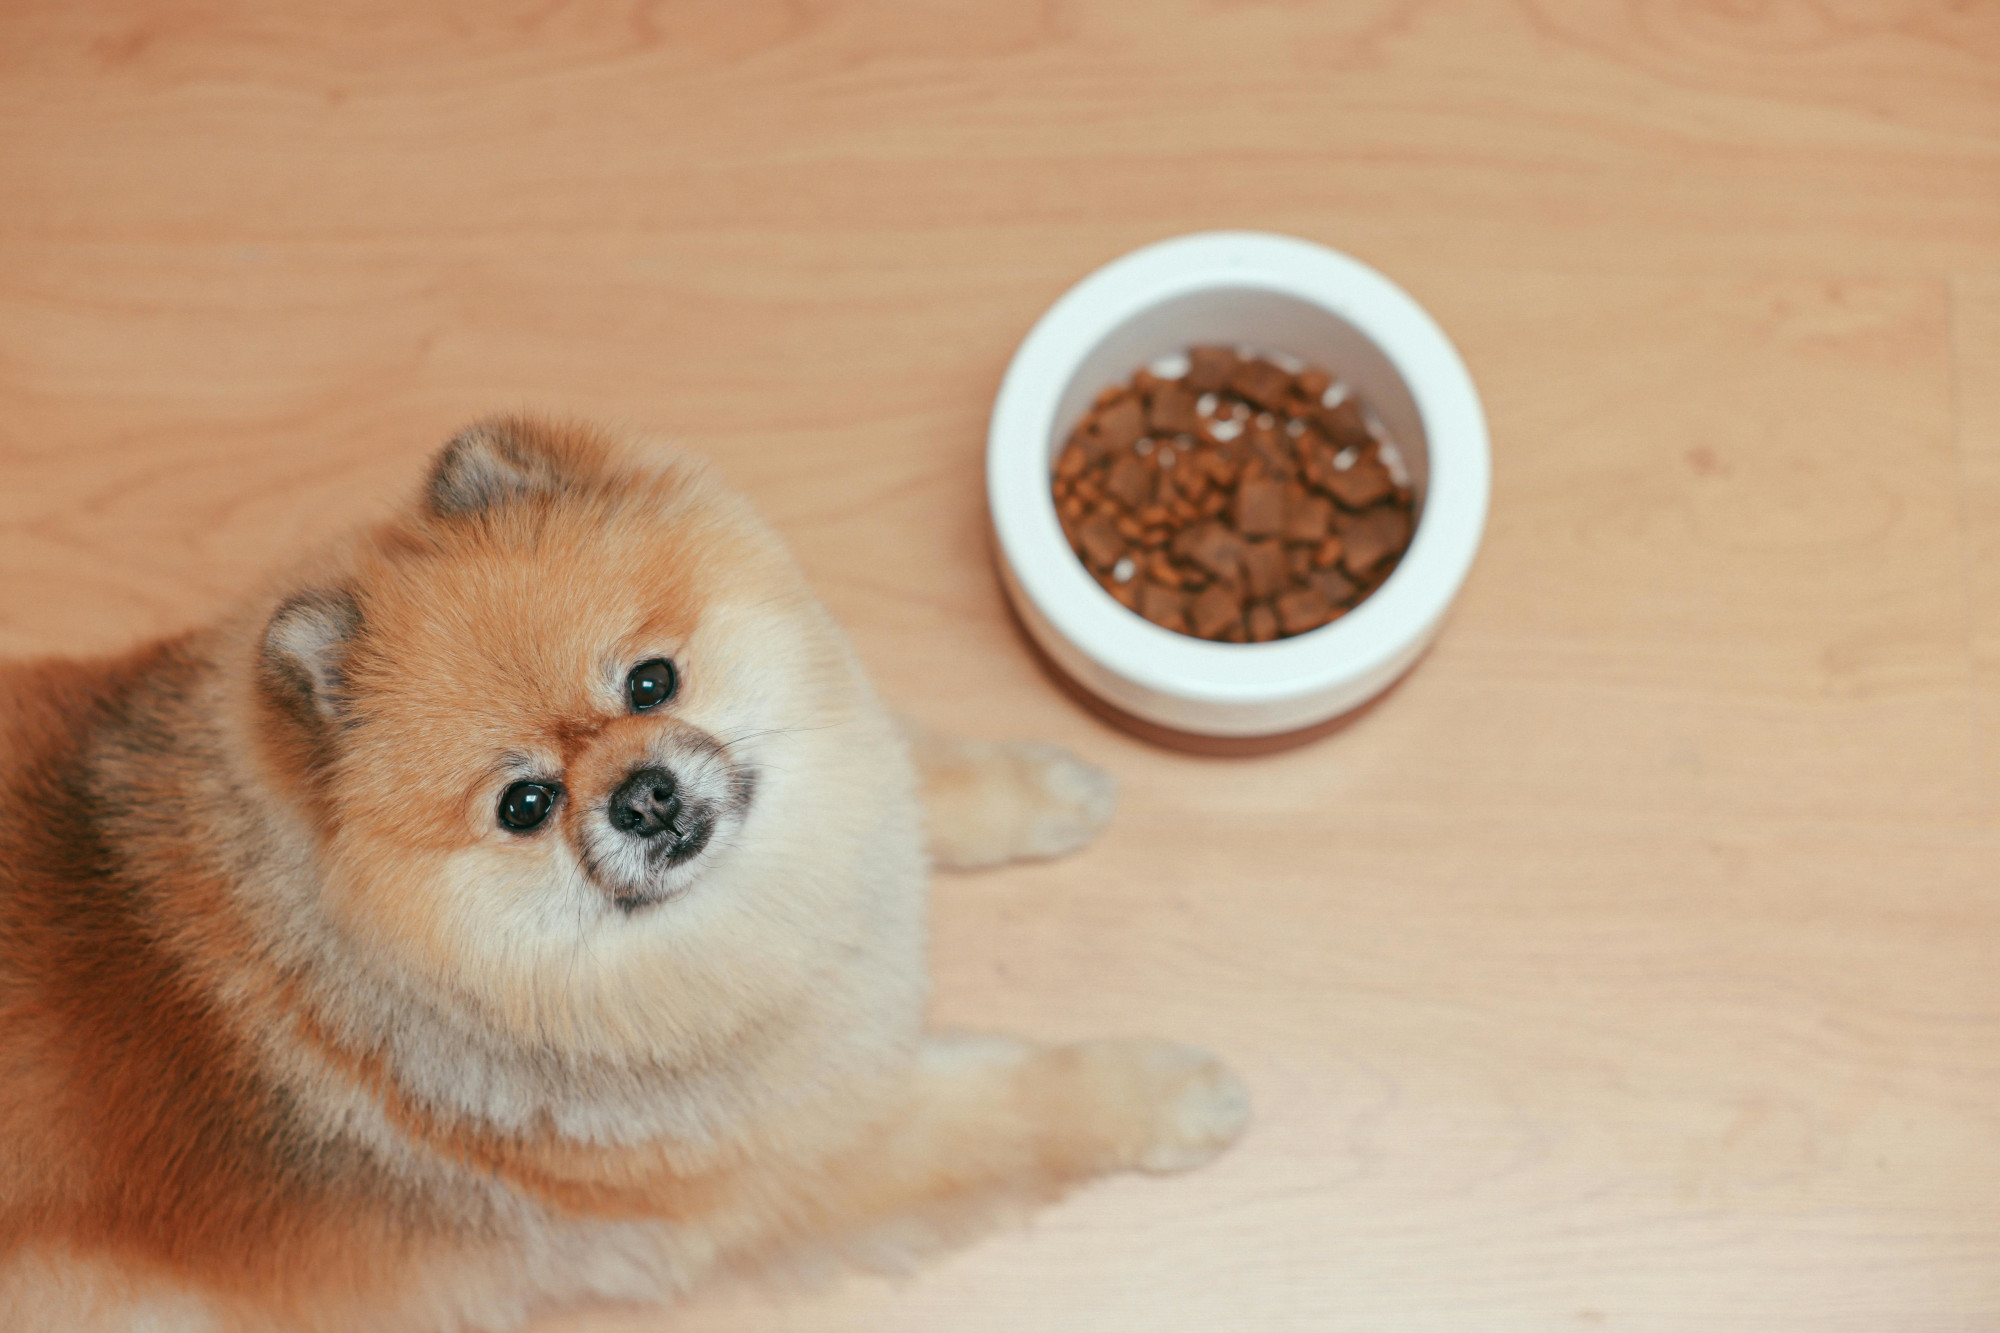

The image features a small, fluffy dog with a light-brown coat and dark eyes, accompanied by a white bowl filled with kibble on a wooden floor. The dog is positioned on the left side of the image, while the bowl is situated on the right. The dog's fur appears to be well-groomed, and its ears are perked up, giving it a cute and alert appearance. The kibble in the bowl is brown in color and has a rough texture, suggesting that it is a dry dog food. The wooden floor provides a natural and warm background for the scene, which is likely a home or living room setting. Overall, the image presents a heartwarming and intimate moment between the dog and its food, highlighting the importance of nutrition and care for our furry friends.


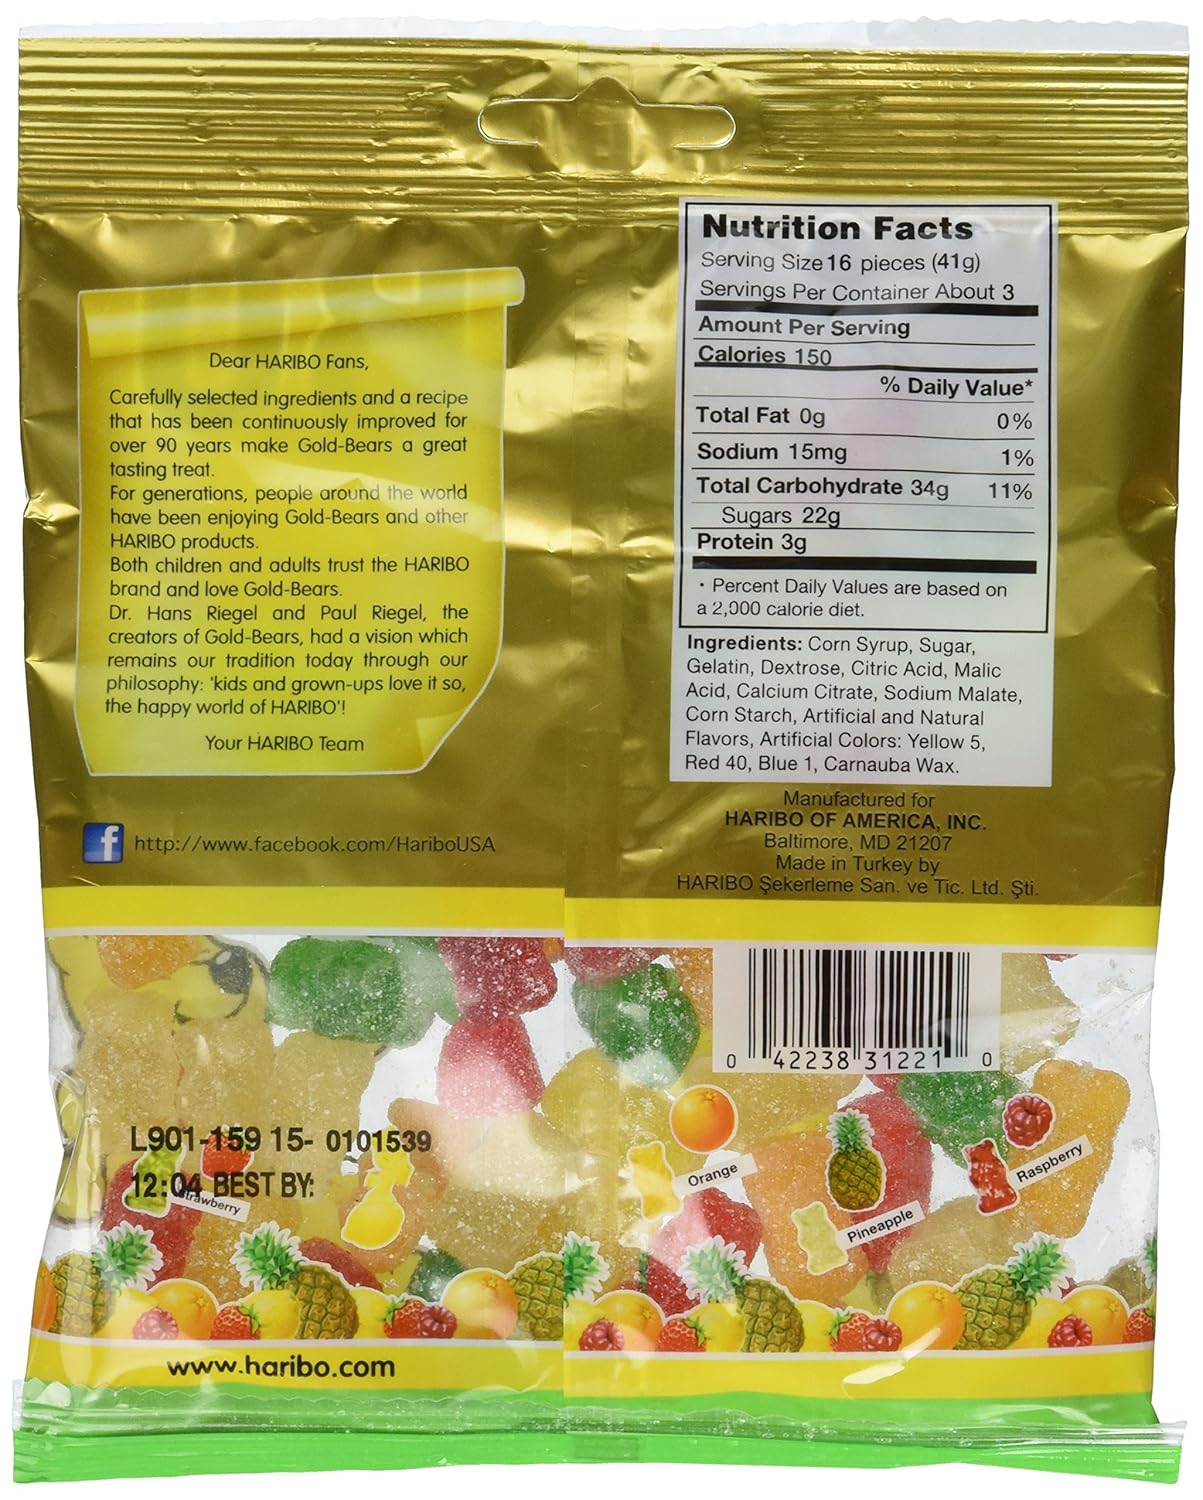

The image shows the back of a Haribo Gold-Bears bag, featuring a gold and yellow color scheme with a clear plastic window showcasing the gummy bears inside. The bag is sealed at the top with a ziplock closure and has a nutrition label on the right side, providing information on serving size, calories, fat, sodium, carbohydrates, sugars, and protein. The bottom of the bag displays a colorful illustration of various fruits, including strawberries, pineapples, and oranges, along with the company's website and social media information. The overall design of the bag is visually appealing and effectively communicates the product's ingredients and nutritional content.


In [22]:
QA_BASE_PATH = "images/qa/"
prompt = "What is in this image? Describe in detail."
# ask the LLM about the images:
for filename in os.listdir(QA_BASE_PATH):
    file_type = filename.split('.')[-1]
    image_data = ""
    file = os.path.join(QA_BASE_PATH, filename)
    with open(file, 'rb') as f:
        # the image data must be base64 encoded
        image_data = base64.b64encode(f.read()).decode()
    # Images can be queried by attaching another message part to the content:
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/{file_type};base64,{image_data}"},
            },
        ],
    )
    # Call the LLM with the images
    result = llm.invoke([message])
    # show the image we just sent (in jupyter notebook)
    display(DisplayImage(filename=file, width=600, unconfined=True))
    # print the LLM's response
    print(result.content)

# Image Classification

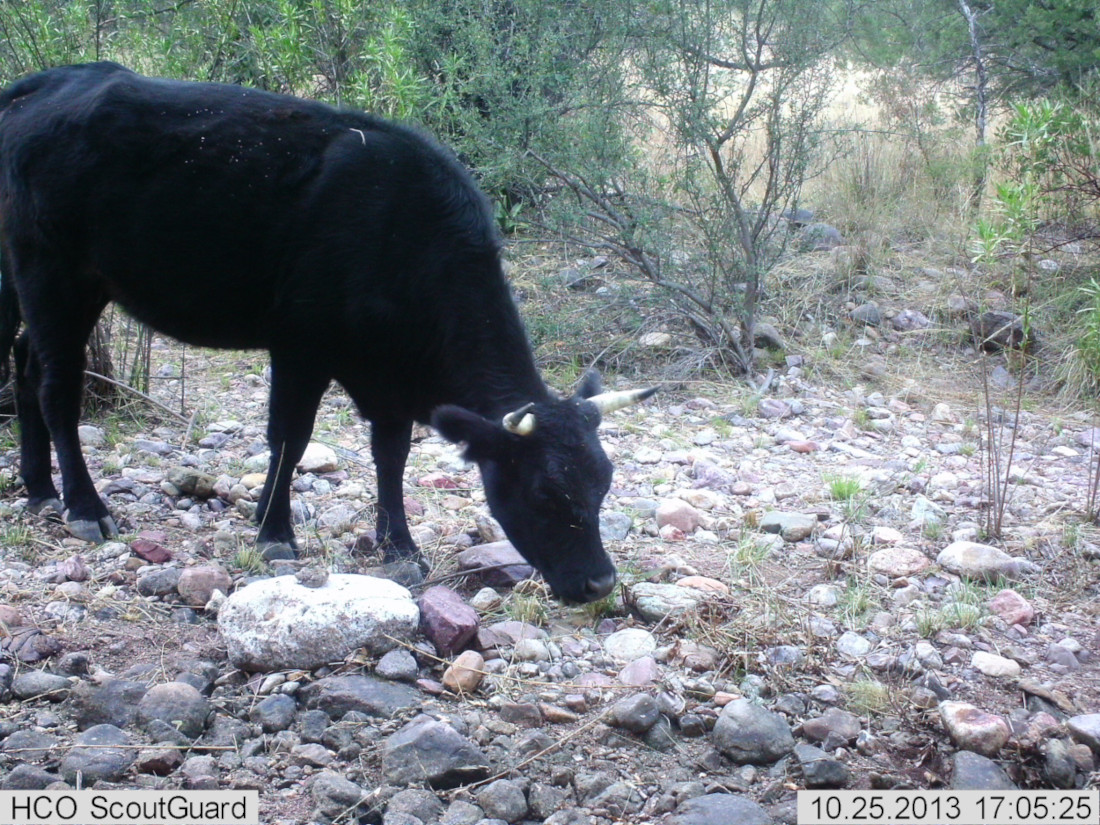

animal='Cow'


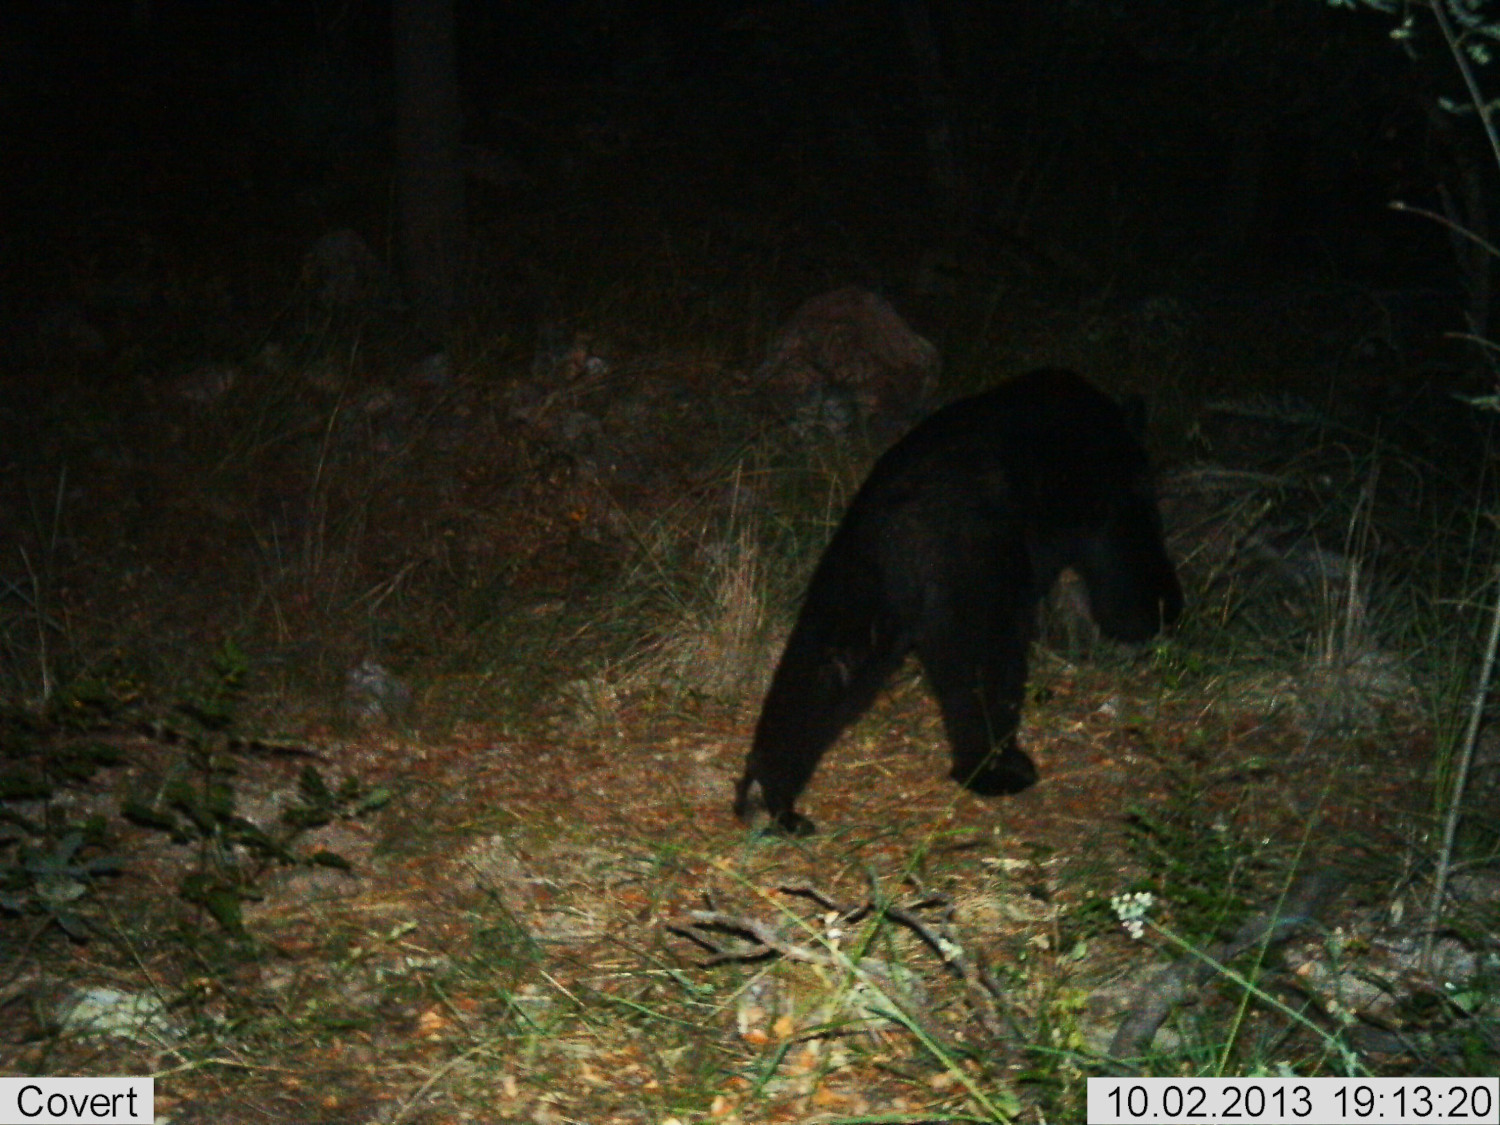

animal='Black Bear'


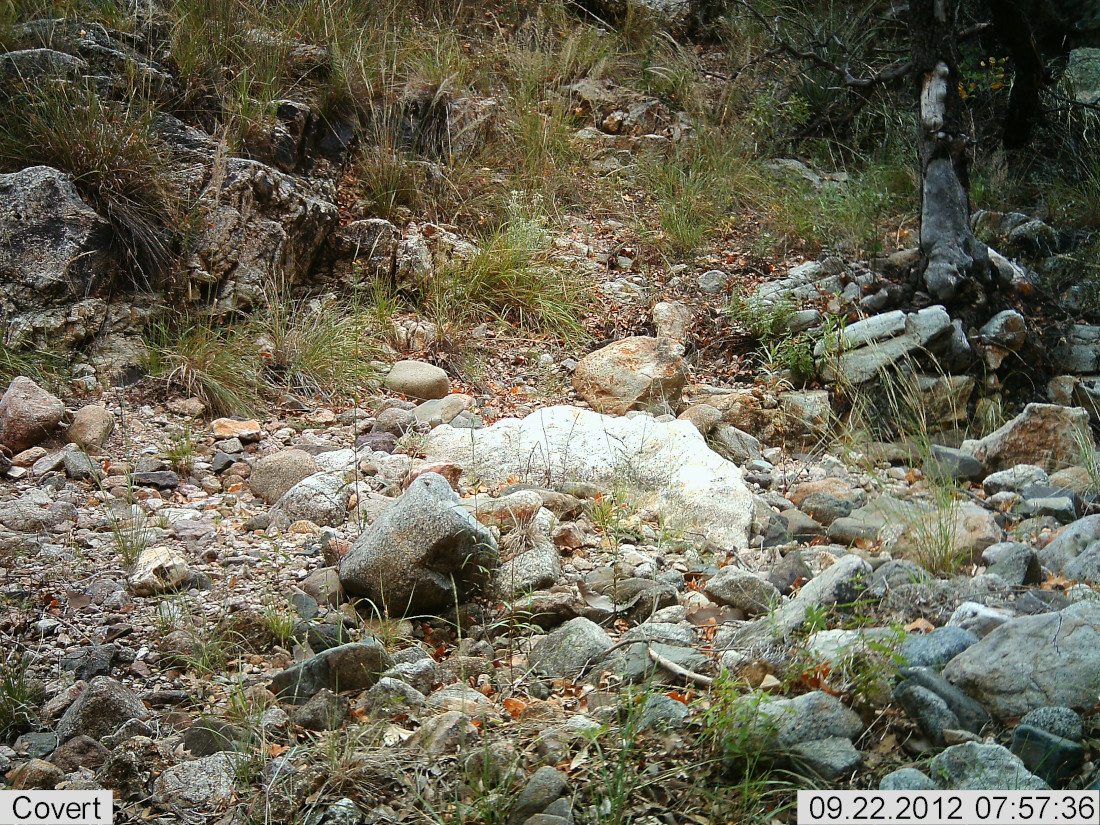

animal='None'


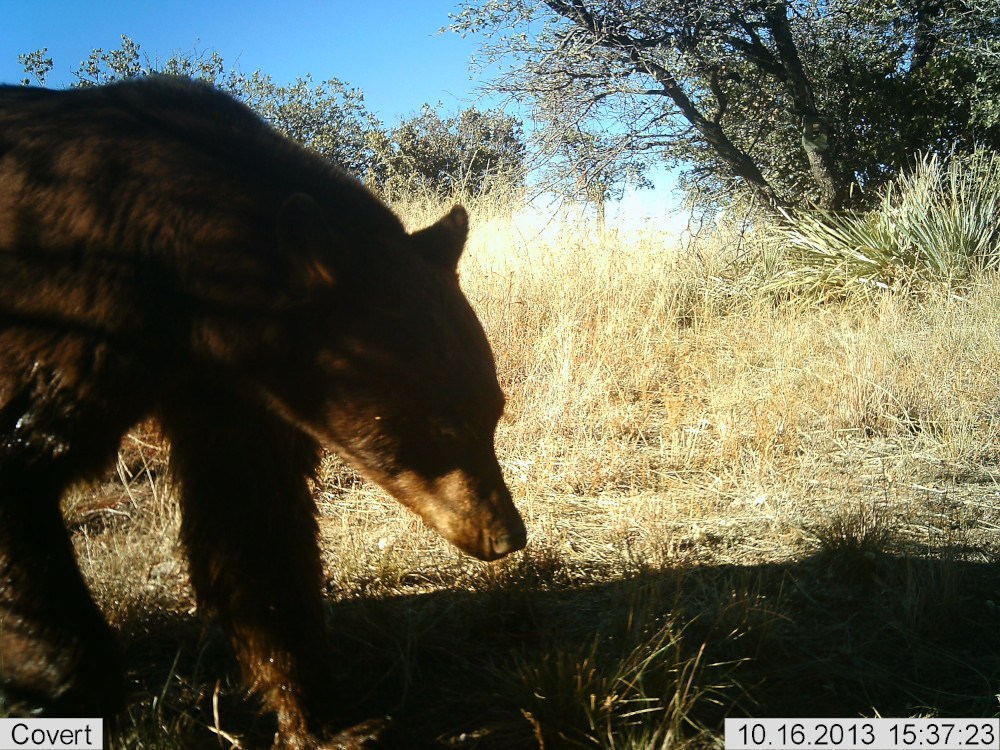

animal='Black Bear'


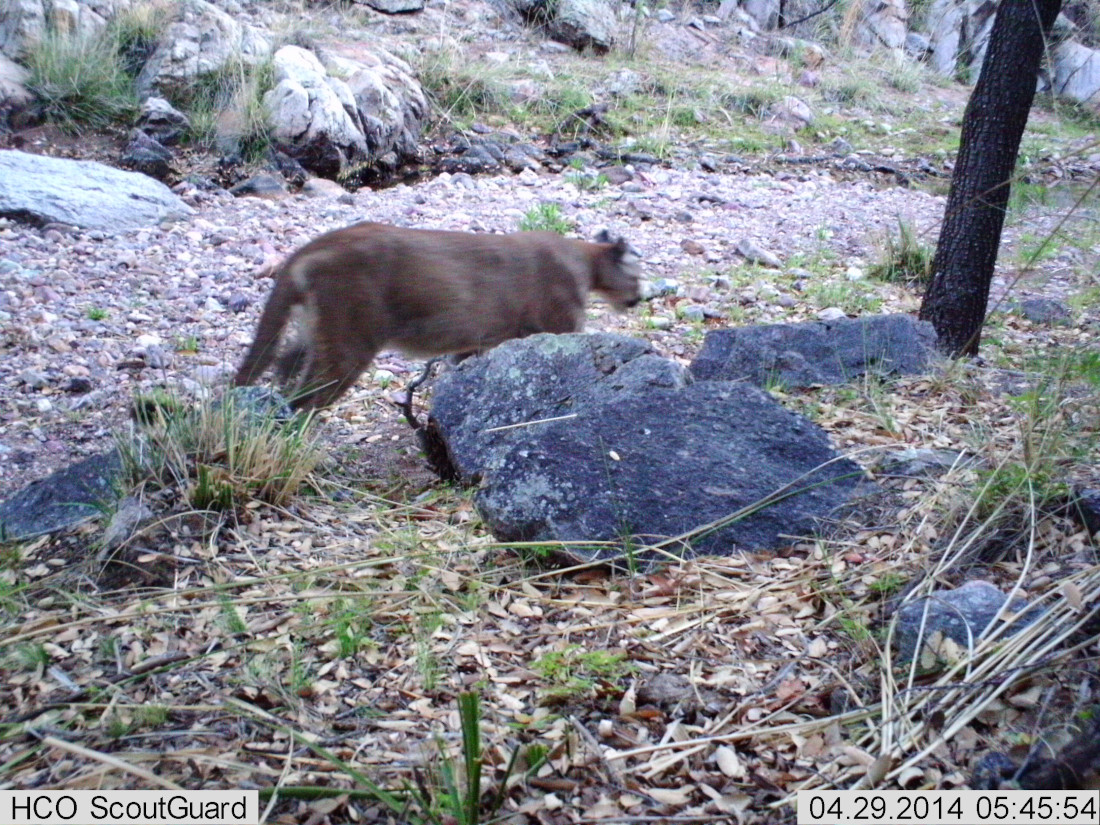

animal='White-tailed Deer'


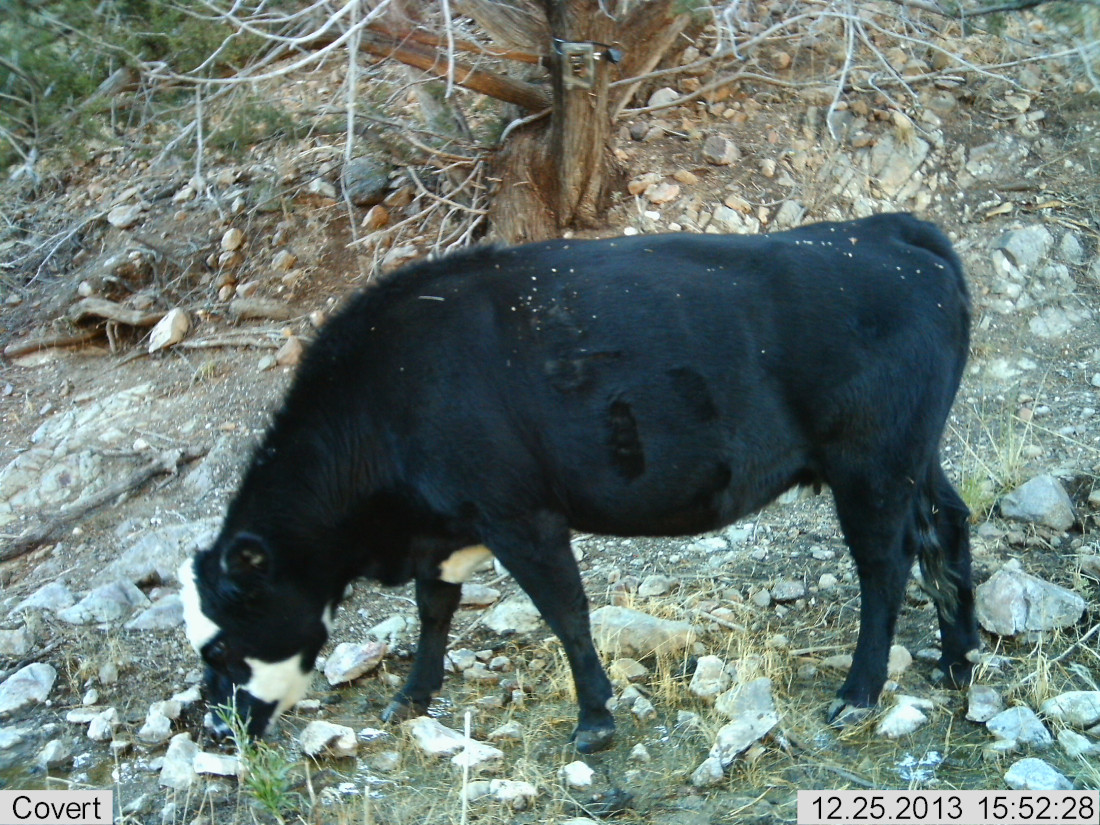

animal='Cow'


In [26]:
# structured output
class ClassifyResults(BaseModel):
    """Results from classifying an image."""
    animal: str = Field(
        description="Animal found in image."
    )

structured_llm = llm.with_structured_output(ClassifyResults)
prompt = "You are an expert image classifier. Determine the animal present in the image. Types of animals include: Birds, Black Bear, Bobcat, Cow, Dog, Gray Fox, Horse, Human, Javelina, Opossum, Puma, Skunk, Squirrels, Turkey, White-tailed Deer. If no animal exists, count that as None."
CLASSIFICATION_BASE_PATH = "images/classification/"
for filename in os.listdir(CLASSIFICATION_BASE_PATH):
    file_type = filename.split('.')[-1]
    image_data = ""
    file = os.path.join(CLASSIFICATION_BASE_PATH, filename)
    with open(file, 'rb') as f:
        image_data = base64.b64encode(f.read()).decode()
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/{file_type};base64,{image_data}"},
            },
        ],
    )
    result = structured_llm.invoke([message])
    # show the image we just sent (in jupyter notebook)
    display(DisplayImage(filename=file, width=600, unconfined=True))
    # print the LLM's response
    print(result)

In [63]:
# note on image sizes: if an image is too large for the model, it will fail with a 413 "request entity too large" error
# we can do some image resizing on the fly with python PIL
really_large_image = "images/413_too_large.jpg"
image_data = ""
with open(really_large_image, 'rb') as f:
    image_data = base64.b64encode(f.read()).decode()
message = HumanMessage(
    content=[
        {"type": "text", "text": "what is in this image?"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpg;base64,{image_data}"},
        },
    ],
)
# result = llm.invoke([message])
# APIStatusError: Error code: 413 - {'error': {'message': "litellm.APIError: APIError: OpenAIException - <html>\r\n<head><title>413 Request Entity Too Large</title></head>\r\n<body>\r\n<center><h1>413 Request Entity Too Large</h1></center>\r\n<hr><center>nginx</center>\r\n</body>\r\n</html>No fallback model group found for original model_group=Llama-3.2-11B-Vision-Instruct. Fallbacks=[{'Meta-Llama-3.1-70B-Instruct-quantized': ['anvilgpt/llama3:70b', 'js2/Llama-3.3-70B-Instruct-FP8-Dynamic']}]\nReceived Model Group=Llama-3.2-11B-Vision-Instruct\nAvailable Model Group Fallbacks=None\nError doing the fallback: litellm.APIError: APIError: OpenAIException - <html>\r\n<head><title>413 Request Entity Too Large</title></head>\r\n<body>\r\n<center><h1>413 Request Entity Too Large</h1></center>\r\n<hr><center>nginx</center>\r\n</body>\r\n</html>No fallback model group found for original model_group=Llama-3.2-11B-Vision-Instruct. Fallbacks=[{'Meta-Llama-3.1-70B-Instruct-quantized': ['anvilgpt/llama3:70b', 'js2/Llama-3.3-70B-Instruct-FP8-Dynamic']}] LiteLLM Retried: 1 times, LiteLLM Max Retries: 2", 'type': None, 'param': None, 'code': '413'}}
from PIL import Image
from io import BytesIO
img = Image.open(really_large_image)
print('initial', img.size)
base_width = 1100
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
print('new', img.size)
buff = BytesIO()
img.save(buff, format="JPEG")
buff.seek(0)
message = HumanMessage(
    content=[
        {"type": "text", "text": "what is in this image?"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpg;base64,{base64.b64encode(buff.read()).decode()}"},
        },
    ],
)
result = llm.invoke([message])
print(result)

initial (2560, 1920)
new (1100, 825)
content='The image shows a wild turkey in a rocky area.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 6421, 'total_tokens': 6433, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.2-11B-Vision-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-8bd98feb-e3df-4492-8d65-8c1acac6ff8d-0' usage_metadata={'input_tokens': 6421, 'output_tokens': 12, 'total_tokens': 6433, 'input_token_details': {}, 'output_token_details': {}}


In [65]:
# we can also directly pass images to the model.
image_url = "https://highlandcanine.com/wp-content/uploads/2021/03/pomeranian-running-and-happy.jpg"
# we can get around the 413 request too large error for big images by passing them in via an internet accessible url
# image_url = "https://upload.wikimedia.org/wikipedia/commons/c/cb/Pomeranian_orange-sable_Coco.jpg"
message = HumanMessage(
    content=[
        {"type": "text", "text": "what is in this image?"},
        {
            "type": "image_url",
            "image_url": {"url": f"{image_url}"},
        },
    ],
)
result = llm.invoke([message])
print(result)

content='The image features a small, fluffy dog with a long, orange coat and a black nose. The dog appears to be a Pomeranian, a breed known for its small size and thick, double coat. The dog is standing on a wooden deck or porch, with a metal railing visible behind it. The background of the image is out of focus, but it appears to be a house or building with a wooden exterior. Overall, the image suggests that the dog is a beloved pet that is being cared for and loved by its owner.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 6421, 'total_tokens': 6530, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.2-11B-Vision-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-5d76c211-5a80-43d2-9dc8-85f017ed10ac-0' usage_metadata={'input_tokens': 6421, 'output_tokens': 109, 'total_tokens': 6530, 'input_token_details': {}, 'output_token_det